In [ ]:
# Copyright 2024 Reddit, Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Bonus Use Case. Text To Speech

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/reddit/kdd2024-tutorial-breaking-barriers/blob/master/Bonus_Use_Case_Text_to_Speech.ipynb)

## Overview

This notebook provides a hands-on guide to deploying and prompting several text-to-speech model pipelines, as a bonus use case for increasing accessibility.

---

## Setting Up Google Colab
Google Colab provides a convenient platform to run Python code in the cloud, with access to powerful computing resources, including GPUs. For this tutorial, it is recommended to enable GPU acceleration:

1.   Click on *Runtime* in the top menu.
2.   Select *Change runtime type*.
3.   In the dialog that appears, under *Hardware accelerator*, choose **T4 GPU** (or any other GPU that you may have access to) if it is not already enabled.
4.   Click *Save*.

---

## Requirements

The code in this notebook is based on Transformers and hugging face datasets, so we need to install all necessary requirements.

**❗Important❗** You may need to restart the Colab session after the *datasets* library has been installed. To do so, go to **Runtime** menu, click on *Restart session* and finally run the cells from the **Settings** section.

In [ ]:
!pip -q install datasets

---

## Settings

Run the following cells to make some convenient settings.

In [ ]:
# Disable Transformer warnings
import logging
logging.basicConfig(level=logging.INFO)

import transformers
transformers.logging.set_verbosity_error()

import warnings
warnings.filterwarnings('ignore')

# Set GPU device
import torch
torch.set_default_device("cuda") # or "cpu" is GPU is not available

Some useful imports:

In [ ]:
from IPython.display import Audio
from datasets import load_dataset
from transformers import SpeechT5Processor
from transformers import SpeechT5ForTextToSpeech
from transformers import SpeechT5HifiGan
from transformers import BarkModel
from transformers import AutoProcessor

### Check if we're using CPU or GPU

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

---

## Model 1: SpeechT5

SpeechT5 model [1] can handle a bunch of speech-related tasks, but here we will focus on the text-to-speech (TTS) task. The output is a log mel spectrogram, but we need the output to be a waveform. The way of doing it is by using an additional neural network known as a vcoder.

#### **References**
[1] Junyi Ao, Rui Wang, Long Zhou, Chengyi Wang, Shuo Ren, Yu Wu, Shujie Liu, Tom Ko, Qing Li, Yu Zhang, Zhihua Wei, Yao Qian, Jinyu Li, and Furu Wei. SpeechT5: Unified-Modal Encoder-Decoder Pre-Training for Spoken Language Processing. [arXiv:2310.03744](https://arxiv.org/abs/2110.07205) [cs.CV]

### Load the SpeechT5 TTS model

In [ ]:
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts").to(device)

### Test Post

The [r/stories](https://www.reddit.com/r/stories/) subreddit provides interesting high quality posts. For this purpose we are going to use a fragment of [this post](https://www.reddit.com/r/stories/comments/1dnd5h0/i_found_an_endless_hole_on_some_land_i_recently/), but **go ahead and try your own texts!**

In [ ]:
text = """
I recently bought some land and a small cabin on the outskirts of Frost Hollow. The town had been in decline for decades. A constant stream of businesses and people left Frost Hollow every year. I heard rumors about high missing persons rates as well as insane homicide and suicide rates that plagued the town constantly. This didn’t bother me in the least, however. In my mind, it just meant the land there was dirt-cheap, and that I wouldn’t have too many neighbors to worry about.

My closest neighbor, Art, was a sheep farmer, an ancient man with a cantankerous voice and a back like a broken board. He stood only about five feet tall, always wearing his trademark blue coveralls and a wide-brim hat. When I first found the hole, I tried shining a light down and then throwing heavy rocks inside. When only silence greeted me after a minute, I quickly realized that neither method would help me realize the depth of the hole.
"""

### Preprocess the text

The max input size for this specific model is 600 characters, so we need to cut the input to fit the model needs. We can concatenate multiple model outputs to obtain larger audios.

In [ ]:
inputs = processor(text=text[:600], return_tensors="pt").to(device)

### Load the speaker **xVectors**

One of the best features from SpeechT5 is that the model is not limited to creating speech for a single speaker. You can use *speaker embeddings* that capture the characteristics of a particular speaker voice to apply it to your text.

For this particular example, we will be using the X-Vectors [1] from the [CMU ARCTIC dataset](http://www.festvox.org/cmu_arctic/) (note that this specific dataset is trained only with english language). We will download multiple speaker embeddings so we can try different speaker voices.

#### **References**
D. Snyder, D. Garcia-Romero, G. Sell, D. Povey and S. Khudanpur. X-Vectors: Robust DNN Embeddings for Speaker Recognition. 2018 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP), Calgary, AB, Canada, 2018, pp. 5329-5333, doi: [10.1109/ICASSP.2018.8461375](https://www.danielpovey.com/files/2018_icassp_xvectors.pdf).

In [ ]:
embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")

woman_speaker_embeddings = torch.tensor(embeddings_dataset[7306]["xvector"]).unsqueeze(0).to(device)
man_speaker_embeddings = torch.tensor(embeddings_dataset[1500]["xvector"]).unsqueeze(0).to(device)

### Use a Vcoder to get the results in waveform


In [ ]:
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan").to(device)

### Generate the speech


#### With female voice

In [ ]:
speech = model.generate_speech(inputs["input_ids"], woman_speaker_embeddings, vocoder=vocoder).cpu()
Audio(speech, rate=16000)

#### With male voice

In [ ]:
speech = model.generate_speech(inputs["input_ids"], man_speaker_embeddings, vocoder=vocoder).cpu()
Audio(speech, rate=16000)

## Model 2: Bark

Bark [1] is a transformer-based text-to-audio model created by Suno. Bark can generate highly realistic, multilingual speech as well as other audio - including music, background noise and simple sound effects. The model can also produce nonverbal communications like laughing, sighing and crying.

- [GitHub Project](https://github.com/suno-ai/bark)
- [Model in Huggingface Hub](https://huggingface.co/suno/bark)

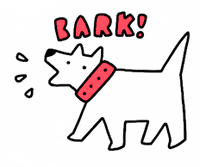



Unlike SpeechT5, bark generates waveforms directly, so we don't need to use vcoders to obtain the final audio results (it's not that it doesn't use vcoders, but it's already integrated into the model itself).




In [ ]:
model = BarkModel.from_pretrained("suno/bark-small").to(device)
processor = AutoProcessor.from_pretrained("suno/bark-small")

### Text preprocessing

We will be using the same example text as in SpeechT5.

The best thing about bark is that we already have a preset libraries for
defining speaker characteristics in **multiple languages** that can be found [here](https://suno-ai.notion.site/8b8e8749ed514b0cbf3f699013548683?v=bc67cff786b04b50b3ceb756fd05f68c).



In [ ]:
# add a speaker embedding
inputs = processor(text, voice_preset="v2/en_speaker_6").to(device)

### Generate model outputs

In [ ]:
speech_output = model.generate(**inputs).cpu().numpy()

In [ ]:
sampling_rate = model.generation_config.sample_rate
Audio(speech_output[0], rate=sampling_rate)

The coolest thing about bark is that you can include some special patterns to emulate some speaker *actions* like:

* [laughter]
* [laughs]
* [sighs]
* [music]
* [gasps]
* [clears throat]
* — or ... for hesitations
* ♪ for song lyrics
* CAPITALIZATION for emphasis of a word
* [MAN] and [WOMAN] to bias Bark toward male and female speakers, respectively (even though if you choose a voice preset this won't be needed unless you want to emulate a conversation between multiple characters)

This patterns are not something that the creators intended to create, these patterns have been discovered afterwards when people started using the model. So if you discover any new one, [let them know!](https://github.com/suno-ai/bark?tab=readme-ov-file#%EF%B8%8F-details)


### Model testing

This is a simple class to play with the model and its different possibilities with ease.


In [ ]:
class BarkModelTester:
  def __init__(self, model, processor):
    self.model = model
    self.processor = processor

  def generate_speech(self, text, voice_preset="v2/en_speaker_6", **kwargs):
    inputs = self.processor(text, voice_preset=voice_preset).to(device)
    speech_output = self.model.generate(**inputs).cpu().numpy()
    sampling_rate = model.generation_config.sample_rate
    return Audio(speech_output[0], rate=sampling_rate)

In [ ]:
# Load model
bark_model = BarkModelTester(model, processor)

In [ ]:
# Test 1
bark_model.generate_speech("HELLO, I'm Bark!")

In [ ]:
# Test 2
bark_model.generate_speech("Who let the dogs out? (Who, who, who, who, who?)")

In [ ]:
# Text in Spanish
es_text = "En un lugar de la Mancha, de cuyo nombre no quiero acordarme, no ha mucho tiempo que vivía un hidalgo de los de lanza en astillero, adarga antigua, rocín flaco y galgo corredor."

In [ ]:
bark_model.generate_speech(es_text, "v2/es_speaker_9")

In [ ]:
bark_model.generate_speech(es_text, "v2/es_speaker_0")

# Discussion: How Text to Speech Generation with Multimodal LLMs can improve Accessibility in Social Media

- **Overcoming Text Barriers**: LLMs provide access to individuals with reading disabilities like dyslexia, and allows consumption of text-heavy content for those with visual impairments or fatigue, making social media participation easier.
- **Enhancing Content Consumption**: Offers alternative ways to experience social media for users with different learning styles (auditory learners). Enables multitasking by listening to content while engaging in other activities.

- **Promoting Inclusivity & Engagement**: Allows users with speech impairments to participate more actively by converting their generated text to speech.

- **Harnessing Multimodal Capabilities**: Enables emotionally nuanced speech synthesis by incorporating visual cues from images or videos in the post.

- **Personalized Experience**: Users could customize voice, language, and speaking speed to their preferences, thus offering a more engaging and enjoyable social media experience for everyone.